In [1]:
import time
import sys, os
import pickle
import numpy as np
import scvelo as scv
import scanpy
import scipy
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import optim
from veloproj import *
from veloproj.model import leastsq_pt
from IPython import display
from matplotlib import pyplot as plt
import anndata

In [2]:
parser = get_parser()
args = parser.parse_args(args=['--lr', '1e-6', 
                               '--n-epochs', '20000', 
                               '--data-dir', '/data/users/cqiao/notebooks/projects/PaperRev/VeloRep2/endocrinogenesis_day15.5.h5ad',
                               '--g-rep-dim', '100',
                               '--k-dim', '100',
                               '--exp-name', 'baseline_pancreas',
                               '--model-name', 'baseline_tmp.cpt',
                               '--device', 'cuda:3',
                               '--gumbsoft_tau', '1',
                               '--nb_g_src', "SU",
                               '--n_raw_gene', '2000',
                              ])

In [3]:
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
np.random.seed(args.seed)
torch.backends.cudnn.deterministic = True

device = torch.device(args.device if args.device.startswith('cuda') and torch.cuda.is_available() else "cpu")

In [4]:
cluster_edges = [
    ("Ngn3 low EP", "Ngn3 high EP"), 
    ("Ngn3 high EP", "Fev+"), 
    ("Fev+", "Alpha"), 
    ("Fev+", "Beta"), 
    ("Fev+", "Delta"), 
    ("Fev+", "Epsilon")]
k_cluster = "clusters"
EXP_NAME = args.exp_name
exp_metrics = {}

In [5]:
def main_AE(args, model, lr=args.lr, weight_decay=args.weight_decay, save_name="tmp.cpt"):
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    lr = args.lr  
    i, losses = 0, [sys.maxsize]  
    min_loss = losses[-1]
    model_saved = False

    model.train()
    while i < args.n_epochs:
        i += 1
        loss = train_step_AE([tensor_s, tensor_u], model, optimizer, xyids=[0, 1], device=device)
        losses.append(loss)
        if i % args.log_interval == 0:
            if losses[-1] < min_loss:
                min_loss = losses[-1]
                torch.save(model.state_dict(), os.path.join(args.output, save_name))
                model_saved = True
            else:
                if model_saved:
                    model.load_state_dict(torch.load(os.path.join(args.output, save_name)))
                    model = model.to(device)
                lr *= args.lr_decay
                for param_group in optimizer.param_groups:
                    param_group['lr'] = lr

            print("Train Epoch: {:2d}/{:2d} \tLoss: {:.6f}"
                  .format(i, args.n_epochs, losses[-1]))

    plt.plot(losses[1:])
    if losses[-1] < min_loss:
        torch.save(model.state_dict(), os.path.join(args.output, save_name))
    return model

In [6]:
adata = scanpy.read_h5ad(args.data_dir)
scv.pp.neighbors(adata, n_neighbors=30, n_pcs=30)
scv.utils.show_proportions(adata)
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=args.n_raw_gene)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
print(adata)

computing neighbors
    finished (0:00:14) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
Abundance of ['spliced', 'unspliced']: [0.81 0.19]
Filtered out 22769 genes that are detected 30 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
AnnData object with n_obs × n_vars = 2531 × 2000
    obs: 'day', 'proliferation', 'G2M_score', 'S_score', 'phase', 'clusters_coarse', 'clusters', 'clusters_fine', 'louvain_Alpha', 'louvain_Beta', 'palantir_pseudotime', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts'
    var: 'highly_variable_genes', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'clusters_colors', 'clusters_fine_colors', 'louvain_Alpha_colors', 'louvain_Beta_colors',

computing velocities
    finished (0:00:00) --> added 
    'stc_velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:05) --> added 
    'stc_velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'stc_velocity_length' (adata.obs)
--> added 'stc_velocity_confidence' (adata.obs)
--> added 'stc_velocity_confidence_transition' (adata.obs)
computing velocity embedding
    finished (0:00:00) --> added
    'stc_velocity_umap', embedded velocity vectors (adata.obsm)


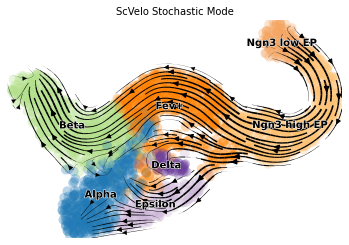

# Cross-Boundary Transition Score (A->B)
{('Ngn3 low EP', 'Ngn3 high EP'): 0.1562318, ('Ngn3 high EP', 'Fev+'): 0.23484711, ('Fev+', 'Alpha'): 0.19807771, ('Fev+', 'Beta'): 0.24194431, ('Fev+', 'Delta'): 0.19956161, ('Fev+', 'Epsilon'): 0.102914006}
Total Mean: 0.18892942368984222
# Cross-Boundary Velocity Coherence (A->B)
{('Ngn3 low EP', 'Ngn3 high EP'): 0.97805756, ('Ngn3 high EP', 'Fev+'): 0.8823927, ('Fev+', 'Alpha'): 0.71744776, ('Fev+', 'Beta'): 0.65568346, ('Fev+', 'Delta'): 0.79728156, ('Fev+', 'Epsilon'): 0.8656598}
Total Mean: 0.8160871863365173
# Cross-Boundary Direction Correctness (A->B)
{('Ngn3 low EP', 'Ngn3 high EP'): 0.8427982312164871, ('Ngn3 high EP', 'Fev+'): 0.6803993679147251, ('Fev+', 'Alpha'): 0.4605180649571019, ('Fev+', 'Beta'): 0.7558329745334402, ('Fev+', 'Delta'): 0.11593188548526835, ('Fev+', 'Epsilon'): 0.016872912469065283}
Total Mean: 0.4787255727626814
# In-cluster Coherence
{'Alpha': 0.72817206, 'Beta': 0.74304336, 'Delta': 0.776115, 'Epsilon': 0.855

In [7]:
scv.tl.velocity(adata, vkey='stc_velocity', mode="stochastic")
scv.tl.velocity_graph(adata, vkey='stc_velocity')
scv.tl.velocity_confidence(adata, vkey='stc_velocity')
scv.pl.velocity_embedding_stream(adata, vkey="stc_velocity", basis='X_umap', color=k_cluster,
                                title='ScVelo Stochastic Mode')
exp_metrics["stc_mode"] = evaluate(adata, cluster_edges, k_cluster, "stc_velocity")

In [8]:
spliced = adata.layers['Ms']
unspliced = adata.layers['Mu']
tensor_s, tensor_u = torch.FloatTensor(spliced).to(device), torch.FloatTensor(unspliced).to(device)
tensor_x = torch.FloatTensor(adata.X.toarray()).to(device)
tensor_v = torch.FloatTensor(adata.layers['stc_velocity']).to(device)

Train Epoch: 100/20000 	Loss: 44.327385
Train Epoch: 200/20000 	Loss: 41.748428
Train Epoch: 300/20000 	Loss: 39.882568
Train Epoch: 400/20000 	Loss: 38.522282
Train Epoch: 500/20000 	Loss: 37.530396
Train Epoch: 600/20000 	Loss: 36.732883
Train Epoch: 700/20000 	Loss: 36.091385
Train Epoch: 800/20000 	Loss: 35.603268
Train Epoch: 900/20000 	Loss: 35.249084
Train Epoch: 1000/20000 	Loss: 34.969646
Train Epoch: 1100/20000 	Loss: 34.743584
Train Epoch: 1200/20000 	Loss: 34.587601
Train Epoch: 1300/20000 	Loss: 34.430515
Train Epoch: 1400/20000 	Loss: 34.316219
Train Epoch: 1500/20000 	Loss: 34.177418
Train Epoch: 1600/20000 	Loss: 34.083069
Train Epoch: 1700/20000 	Loss: 33.994152
Train Epoch: 1800/20000 	Loss: 33.923744
Train Epoch: 1900/20000 	Loss: 33.853046
Train Epoch: 2000/20000 	Loss: 33.790749
Train Epoch: 2100/20000 	Loss: 33.729046
Train Epoch: 2200/20000 	Loss: 33.672321
Train Epoch: 2300/20000 	Loss: 33.612476
Train Epoch: 2400/20000 	Loss: 33.557983
Train Epoch: 2500/20000 	

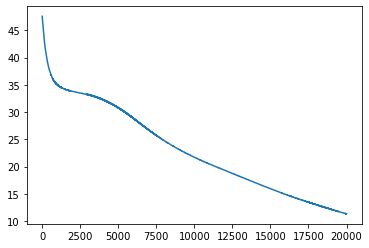

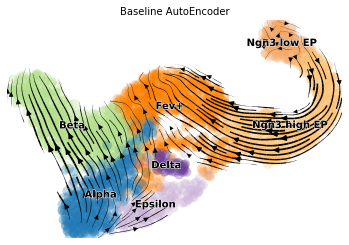

--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{('Ngn3 low EP', 'Ngn3 high EP'): 0.1421494, ('Ngn3 high EP', 'Fev+'): 0.3560849, ('Fev+', 'Alpha'): 0.037719317, ('Fev+', 'Beta'): 0.031558607, ('Fev+', 'Delta'): 0.03677177, ('Fev+', 'Epsilon'): 0.059796095}
Total Mean: 0.11068002134561539
# Cross-Boundary Velocity Coherence (A->B)
{('Ngn3 low EP', 'Ngn3 high EP'): 0.9997898, ('Ngn3 high EP', 'Fev+'): 0.9998087, ('Fev+', 'Alpha'): 0.99955326, ('Fev+', 'Beta'): 0.9995556, ('Fev+', 'Delta'): 0.9994935, ('Fev+', 'Epsilon'): 0.9994938}
Total Mean: 0.9996157288551331
# Cross-Boundary Direction Correctness (A->B)
{('Ngn3 low EP', 'Ngn3 high EP'): -0.24150968890014754, ('Ngn3 high EP', 'Fev+'): 0.7554531469311885, ('Fev+', 'Alpha'): -0.19523412846252922, ('Fev+', 'Beta'): 0.09969707241894676, ('Fev+', 'Delta'): -0.11845439375427899, ('Fev+', 'Epsilon')

In [9]:
def expBaseAE(adata, exp_metrics):
    n_cells, n_genes = adata.X.shape
    in_dim = n_genes
    z_dim = args.z_dim
    h_dim = args.h_dim
    
    model = get_baseline_AE(in_dim, z_dim, h_dim).to(device)
    model = main_AE(args, model, save_name=f"baseAE_{args.model_name}")
    model.eval()
    with torch.no_grad():
        x = model.encoder(tensor_x)
        s = model.encoder(tensor_s)
        u = model.encoder(tensor_u)
        
        _, gamma, _ = leastsq_pt(s, u, 
                                    device=device, 
                                    fit_offset=True, 
                                    perc=[5, 95]
                                    )
        v = (u - gamma * s).cpu().numpy()
        x = x.cpu().numpy()
        s = s.cpu().numpy()
        u = u.cpu().numpy()
        
    adata = new_adata(adata, x, s, u, v, g_basis=args.nb_g_src)
    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, vkey="new_velocity", basis='X_umap', color=k_cluster,
                                    title="Baseline AutoEncoder",
                                    )  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Baseline AutoEncoder'] = evaluate(adata, cluster_edges, k_cluster, "new_velocity")
    
expBaseAE(adata, exp_metrics)

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
Train Epoch: 100/20000 	Loss: 33.811008
Train Epoch: 200/20000 	Loss: 33.724911
Train Epoch: 300/20000 	Loss: 33.675152
Train Epoch: 400/20000 	Loss: 33.645969
Train Epoch: 500/20000 	Loss: 33.623295
Train Epoch: 600/20000 	Loss: 33.603981
Train Epoch: 700/20000 	Loss: 33.587372
Train Epoch: 800/20000 	Loss: 33.570595
Train Epoch: 900/20000 	Loss: 33.552814
Train Epoch: 1000/20000 	Loss: 33.532532
Train Epoch: 1100/20000 	Loss: 33.509628
Train Epoch: 1200/20000 	Loss: 33.482574
Train Epoch: 1300/20000 	Loss: 33.452847
Train Epoch: 1400/20000 	Loss: 33.419369
Train Epoch: 1500/20000 	Loss: 33.382118
Train Epoch: 1600/20000 	Loss: 33.340374
Train Epoch: 1700/20000 	Loss: 33.293949
Train Epoch: 1800/20000 	Loss: 33.24

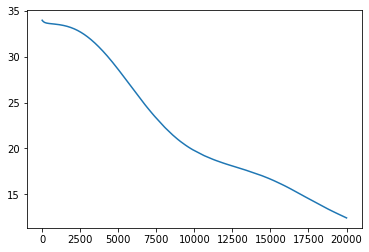

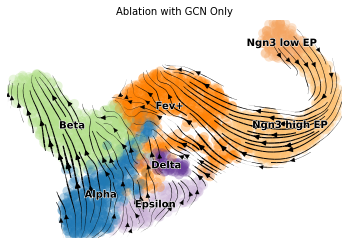

--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{('Ngn3 low EP', 'Ngn3 high EP'): 0.5543728, ('Ngn3 high EP', 'Fev+'): 0.45143175, ('Fev+', 'Alpha'): 0.112882964, ('Fev+', 'Beta'): 0.06548623, ('Fev+', 'Delta'): 0.0403386, ('Fev+', 'Epsilon'): 0.019640472}
Total Mean: 0.20735879242420197
# Cross-Boundary Velocity Coherence (A->B)
{('Ngn3 low EP', 'Ngn3 high EP'): 0.99999696, ('Ngn3 high EP', 'Fev+'): 0.9999924, ('Fev+', 'Alpha'): 0.999992, ('Fev+', 'Beta'): 0.99998856, ('Fev+', 'Delta'): 0.9999884, ('Fev+', 'Epsilon'): 0.9999876}
Total Mean: 0.9999909996986389
# Cross-Boundary Direction Correctness (A->B)
{('Ngn3 low EP', 'Ngn3 high EP'): 0.7018517574101434, ('Ngn3 high EP', 'Fev+'): 0.7303077352467177, ('Fev+', 'Alpha'): -0.07488124995449211, ('Fev+', 'Beta'): 0.20033842266521004, ('Fev+', 'Delta'): -0.12446533448627098, ('Fev+', 'Epsilon'): -

In [10]:
def expAblationCohAgg(adata, exp_metrics):
    n_cells, n_genes = adata.X.shape
    in_dim = n_genes
    z_dim = args.z_dim
    h_dim = args.h_dim
    g_basis = args.nb_g_src
    model = get_ablation_CohAgg(
                                adata,
                                in_dim,
                                z_dim,
                                h_dim,
                                g_basis,
                                device)
    model = main_AE(args, model, save_name=f"CohAgg_{args.model_name}")
    model.eval()
    with torch.no_grad():
        x = model.encoder(tensor_x)
        s = model.encoder(tensor_s)
        u = model.encoder(tensor_u)
        
        _, gamma, _ = leastsq_pt(s, u, 
                                    device=device, 
                                    fit_offset=True, 
                                    perc=[5, 95]
                                    )
        v = (u - gamma * s).cpu().numpy()
        x = x.cpu().numpy()
        s = s.cpu().numpy()
        u = u.cpu().numpy()
        
    adata = new_adata(adata, x, s, u, v, g_basis=args.nb_g_src)
    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, vkey="new_velocity", basis='X_umap', color=k_cluster,
                                    title="Ablation with GCN Only",
                                    )  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Ablation GCN Only'] = evaluate(adata, cluster_edges, k_cluster, "new_velocity")
    
expAblationCohAgg(adata, exp_metrics)

Train Epoch: 100/20000 	Loss: 43.759369
Train Epoch: 200/20000 	Loss: 41.639336
Train Epoch: 300/20000 	Loss: 40.006615
Train Epoch: 400/20000 	Loss: 38.591698
Train Epoch: 500/20000 	Loss: 37.257439
Train Epoch: 600/20000 	Loss: 36.179222
Train Epoch: 700/20000 	Loss: 35.291672
Train Epoch: 800/20000 	Loss: 34.583115
Train Epoch: 900/20000 	Loss: 34.017303
Train Epoch: 1000/20000 	Loss: 33.539852
Train Epoch: 1100/20000 	Loss: 33.096565
Train Epoch: 1200/20000 	Loss: 32.688461
Train Epoch: 1300/20000 	Loss: 32.365505
Train Epoch: 1400/20000 	Loss: 32.064114
Train Epoch: 1500/20000 	Loss: 31.812489
Train Epoch: 1600/20000 	Loss: 31.582756
Train Epoch: 1700/20000 	Loss: 31.363585
Train Epoch: 1800/20000 	Loss: 31.145832
Train Epoch: 1900/20000 	Loss: 30.963636
Train Epoch: 2000/20000 	Loss: 30.791065
Train Epoch: 2100/20000 	Loss: 30.605478
Train Epoch: 2200/20000 	Loss: 30.439949
Train Epoch: 2300/20000 	Loss: 30.272842
Train Epoch: 2400/20000 	Loss: 30.089111
Train Epoch: 2500/20000 	

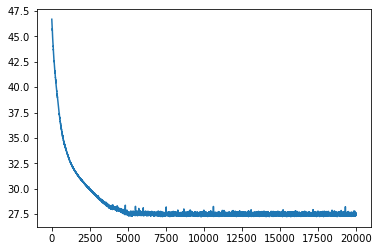

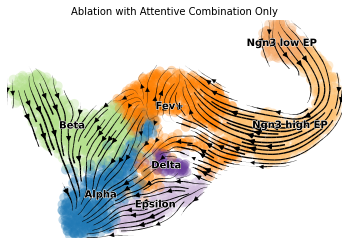

--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{('Ngn3 low EP', 'Ngn3 high EP'): 0.13485867, ('Ngn3 high EP', 'Fev+'): 0.16508213, ('Fev+', 'Alpha'): 0.082500674, ('Fev+', 'Beta'): 0.050647233, ('Fev+', 'Delta'): 0.023729503, ('Fev+', 'Epsilon'): 0.05628438}
Total Mean: 0.08551710098981857
# Cross-Boundary Velocity Coherence (A->B)
{('Ngn3 low EP', 'Ngn3 high EP'): 0.99582493, ('Ngn3 high EP', 'Fev+'): 0.9957834, ('Fev+', 'Alpha'): 0.99114966, ('Fev+', 'Beta'): 0.9936585, ('Fev+', 'Delta'): 0.98309463, ('Fev+', 'Epsilon'): 0.9645201}
Total Mean: 0.9873385429382324
# Cross-Boundary Direction Correctness (A->B)
{('Ngn3 low EP', 'Ngn3 high EP'): 0.6561327818614351, ('Ngn3 high EP', 'Fev+'): 0.7273993544337695, ('Fev+', 'Alpha'): 0.03732265818312348, ('Fev+', 'Beta'): 0.06171373030445846, ('Fev+', 'Delta'): -0.02767251818424519, ('Fev+', 'Epsilon'

In [11]:
def expAblationAttComb(adata, exp_metrics):
    from sklearn.decomposition import PCA
    n_cells, n_genes = adata.X.shape
    z_dim = args.z_dim
    g_rep_dim = args.g_rep_dim
    h_dim = args.h_dim
    k_dim = args.k_dim
    gb_tau = args.gumbsoft_tau
    G_embeddings = PCA(n_components=g_rep_dim).fit_transform(adata.X.T.toarray())
    
    model = get_ablation_attcomb(
        z_dim,
        n_genes,
        n_cells,
        h_dim,
        k_dim,
        G_embeddings,
        g_rep_dim,
        gb_tau,
        device)
    
            
    model = main_AE(args, model, save_name=f"AttComb_{args.model_name}")
    model.eval()
    with torch.no_grad():
        x = model.encoder(tensor_x)
        s = model.encoder(tensor_s)
        u = model.encoder(tensor_u)
        
        _, gamma, _ = leastsq_pt(s, u, 
                                    device=device, 
                                    fit_offset=True, 
                                    perc=[5, 95]
                                    )
        v = (u - gamma * s).cpu().numpy()
        x = x.cpu().numpy()
        s = s.cpu().numpy()
        u = u.cpu().numpy()
    
    adata = new_adata(adata, x, s, u, v, g_basis=args.nb_g_src)
    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, vkey="new_velocity", basis='X_umap', color=k_cluster,
                                    title="Ablation with Attentive Combination Only",
                                    )  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Ablation AttComb Only'] = evaluate(adata, cluster_edges, k_cluster, "new_velocity")
    
expAblationAttComb(adata, exp_metrics)

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocity graph
    finished (0:00:01) --> added 
    'new_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'new_velocity_umap', embedded velocity vectors (adata.obsm)


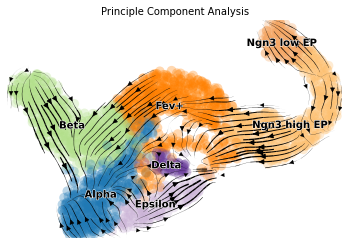

--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{('Ngn3 low EP', 'Ngn3 high EP'): 0.0042930045, ('Ngn3 high EP', 'Fev+'): 0.065521225, ('Fev+', 'Alpha'): 0.023657093, ('Fev+', 'Beta'): 0.028038364, ('Fev+', 'Delta'): 0.08371203, ('Fev+', 'Epsilon'): 0.04685826}
Total Mean: 0.04201332852244377
# Cross-Boundary Velocity Coherence (A->B)
{('Ngn3 low EP', 'Ngn3 high EP'): 0.34991974, ('Ngn3 high EP', 'Fev+'): 0.055823512, ('Fev+', 'Alpha'): 0.16762765, ('Fev+', 'Beta'): 0.15832853, ('Fev+', 'Delta'): 0.09410134, ('Fev+', 'Epsilon'): 0.06552322}
Total Mean: 0.1485539972782135
# Cross-Boundary Direction Correctness (A->B)
{('Ngn3 low EP', 'Ngn3 high EP'): -0.8101321417722663, ('Ngn3 high EP', 'Fev+'): 0.7299031447335071, ('Fev+', 'Alpha'): 0.4205964280752831, ('Fev+', 'Beta'): 0.6145568081636114, ('Fev+', 'Delta'): 0.36806920009357874, ('Fev+', 'Epsi

In [12]:
def expPCA(adata, exp_metrics):
    from sklearn.decomposition import PCA
    pca = PCA(n_components=args.z_dim)
    x, s, u, v = sklearn_decompose(pca, 
                                   tensor_x.detach().cpu().numpy(), 
                                   tensor_s.detach().cpu().numpy(), 
                                   tensor_u.detach().cpu().numpy(), 
                                   tensor_v.detach().cpu().numpy()
                                  )
    
    adata = new_adata(adata, x, s, u, v, g_basis=args.nb_g_src)
    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, vkey="new_velocity", basis='X_umap', color=k_cluster,
                                    title="Principle Component Analysis",
                                    )  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Baseline PCA'] = evaluate(adata, cluster_edges, k_cluster, "new_velocity")
    
expPCA(adata, exp_metrics)

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocity graph
    finished (0:00:01) --> added 
    'new_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'new_velocity_umap', embedded velocity vectors (adata.obsm)


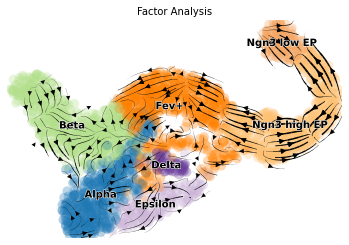

--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{('Ngn3 low EP', 'Ngn3 high EP'): 0.04978139, ('Ngn3 high EP', 'Fev+'): 0.02283617, ('Fev+', 'Alpha'): 0.033024006, ('Fev+', 'Beta'): 0.023198253, ('Fev+', 'Delta'): 0.017309569, ('Fev+', 'Epsilon'): 0.023681648}
Total Mean: 0.02830517292022705
# Cross-Boundary Velocity Coherence (A->B)
{('Ngn3 low EP', 'Ngn3 high EP'): -0.3333549430244391, ('Ngn3 high EP', 'Fev+'): -0.01562630182601651, ('Fev+', 'Alpha'): 0.0024654788619373523, ('Fev+', 'Beta'): 0.12192356146070756, ('Fev+', 'Delta'): 0.6358933522035541, ('Fev+', 'Epsilon'): 0.3403538602048956}
Total Mean: 0.1252758346467732
# Cross-Boundary Direction Correctness (A->B)
{('Ngn3 low EP', 'Ngn3 high EP'): 0.6513495593424976, ('Ngn3 high EP', 'Fev+'): 0.2665299970831971, ('Fev+', 'Alpha'): 0.060691099445162516, ('Fev+', 'Beta'): 0.11768256800869945,

In [13]:
def expFA(adata, exp_metrics):
    from sklearn.decomposition import FactorAnalysis
    method = FactorAnalysis(n_components=args.z_dim)
    x, s, u, v = sklearn_decompose(method,
                                   tensor_x.detach().cpu().numpy(), 
                                   tensor_s.detach().cpu().numpy(), 
                                   tensor_u.detach().cpu().numpy(), 
                                   tensor_v.detach().cpu().numpy()
                                  )
    
    adata = new_adata(adata, x, s, u, v, g_basis=args.nb_g_src)
    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, vkey="new_velocity", basis='X_umap', color=k_cluster,
                                    title="Factor Analysis",
                                    )  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Baseline FA'] = evaluate(adata, cluster_edges, k_cluster, "new_velocity")
    
expFA(adata, exp_metrics)

In [14]:
with open("{}.pkl".format(EXP_NAME), 'wb') as out_file:
    pickle.dump(exp_metrics, out_file)